In [13]:
# Make BAMS time-series plot of Ft. Myers data from Ap
import xarray as xr
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import glob
import os
import string

%run -i wl_stats.py

# Define some colors
noaa_blue = '#1D70B7'
usgs_green = '#2E8B57'
# delft_blue = '#006699' # not very close
# delft_blue = '#0D38E0' #from Ap...still not right
# delft_blue = '#80C9E4' #yet another option
delft_blue ='#0076CE'
UF_orange = '#FA4616'
UF_blue = '#0021A5'
dutch_orange = '#F36C21'
unc_blue = '#7BAFD4'

cb_green = '#7fc97f'
cb_purple = '#beaed4'
cb_orange = '#fdc086'
cb_yellow = '#ffff99'
cb_blue = '#386cb0'
cb_red = '#f0027f'

In [2]:
# Define the time interval for plot and (shorter) time interval for statistics
# Define the clipping time range
stats_start_time = pd.Timestamp('2022-09-27 22:00:00')
stats_end_time = pd.Timestamp('2022-09-30 00:00:00')

# Define the time interval for plot and (shorter) time interval for statistics
# Define the clipping time range
plot_start_time = pd.Timestamp('2022-09-27 00:00:00')
plot_end_time = pd.Timestamp('2022-09-30 00:00:00')

In [3]:
# Read observations from data downloaded from NOAA on 3/25/2025
# Ft Myers is 8725520. Datum is MSL
data_dir = "F:/crs/proj/2025_NOPP_comparison/BAMS_figure/NOAA/"
fn = 'CO-OPS_8725520_met_MSL_hourly.csv'
df = pd.read_csv(data_dir+fn)

df['time'] = pd.to_datetime(df['Date'] + ' ' + df['Time (GMT)'], format='%Y/%m/%d %H:%M')
df.rename(columns={"Verified (m)": "water level"}, inplace=True)
df.drop(columns=["Preliminary (m)"], inplace=True)  # Removes the column permanently

# Clip to plot times
df_obs = df[(df["time"] >= plot_start_time) & (df["time"] <= plot_end_time)]
df_obs

,Date,Time (GMT),Predicted (m),water level,time
0,2022/09/27,00:00,0.168,0.467,2022-09-27 00:00:00
1,2022/09/27,01:00,0.106,0.403,2022-09-27 01:00:00
2,2022/09/27,02:00,0.056,0.347,2022-09-27 02:00:00
3,2022/09/27,03:00,0.026,0.300,2022-09-27 03:00:00
4,2022/09/27,04:00,0.030,0.306,2022-09-27 04:00:00
...,...,...,...,...,...
68,2022/09/29,20:00,0.015,0.533,2022-09-29 20:00:00
69,2022/09/29,21:00,0.070,0.508,2022-09-29 21:00:00
70,2022/09/29,22:00,0.119,0.488,2022-09-29 22:00:00
71,2022/09/29,23:00,0.151,0.467,2022-09-29 23:00:00


In [4]:
# Read ADCIRC data (GMT, m NAVD88)
data_dir = "F:/crs/proj/2025_NOPP_comparison/BAMS_figure/ADCIRC/"
fn = 'ADCIRC_FtMyers_water_level.csv'
df = pd.read_csv(data_dir+fn)
df.rename(columns={"water level (m NAVD88)": "water level"}, inplace=True)

# Compute delta_t in seconds
df["time"] = pd.to_datetime(df["DateTime"], format='mixed')
delta_t = (df["time"].diff().dropna().dt.total_seconds()).iloc[0]
print('Delta_t: ', delta_t)
# Clip to plot times
df = df[(df["time"] >= plot_start_time) & (df["time"] <= plot_end_time)]
# Convert from NAVD88 to MSL (per Rick L.)
df['water level'] += 0.125
df_adcirc = df
df_adcirc

Delta_t:  1200.0


,DateTime,water level,time
72,27-Sep-2022,0.3314,2022-09-27 00:00:00
73,27-Sep-2022 00:20:00,0.3122,2022-09-27 00:20:00
74,27-Sep-2022 00:40:00,0.2926,2022-09-27 00:40:00
75,27-Sep-2022 01:00:00,0.2718,2022-09-27 01:00:00
76,27-Sep-2022 01:20:00,0.2509,2022-09-27 01:20:00
...,...,...,...
284,29-Sep-2022 22:40:00,0.4358,2022-09-29 22:40:00
285,29-Sep-2022 23:00:00,0.4317,2022-09-29 23:00:00
286,29-Sep-2022 23:20:00,0.4239,2022-09-29 23:20:00
287,29-Sep-2022 23:40:00,0.4131,2022-09-29 23:40:00


In [5]:
# Read COAWST data
data_dir = "F:/crs/proj/2025_NOPP_comparison/BAMS_figure/ROMS/"
fn = 'ROMS_FtMyers_water_level.csv'
df = pd.read_csv(data_dir+fn)
df.rename(columns={"WaterLevel": "water level"}, inplace=True)

# Compute delta_t in seconds
df["time"] = pd.to_datetime(df["DateTime"])
delta_t = (df["time"].diff().dropna().dt.total_seconds()).iloc[0]
print('Delta_t: ', delta_t)
# Clip to plot times
df_coawst = df[(df["time"] >= plot_start_time) & (df["time"] <= plot_end_time)]
df_coawst

Delta_t:  3600.0


,DateTime,water level,time
24,2022-09-27 00:00,0.3097,2022-09-27 00:00:00
25,2022-09-27 01:00,0.2264,2022-09-27 01:00:00
26,2022-09-27 02:00,0.1468,2022-09-27 02:00:00
27,2022-09-27 03:00,0.0906,2022-09-27 03:00:00
28,2022-09-27 04:00,0.1596,2022-09-27 04:00:00
...,...,...,...
92,2022-09-29 20:00,0.1792,2022-09-29 20:00:00
93,2022-09-29 21:00,0.2597,2022-09-29 21:00:00
94,2022-09-29 22:00,0.2828,2022-09-29 22:00:00
95,2022-09-29 23:00,0.2566,2022-09-29 23:00:00


In [6]:
# Load Deltares data
data_dir = "F:/crs/proj/2025_NOPP_comparison/BAMS_figure/Deltares/"
fn = '8725520.csv'
df = pd.read_csv(data_dir+fn)

df["time"] = pd.to_datetime(df["time"])
df.rename(columns={"mod": "water level"}, inplace=True)

# Compute delta_t in seconds
delta_t = (df["time"].diff().dropna().dt.total_seconds()).iloc[0]
print('Delta_t: ', delta_t)

# Clip to plot times
df_cosmos = df[(df["time"] >= plot_start_time) & (df["time"] <= plot_end_time)]
df_cosmos

Delta_t:  600.0


,time,obs,pred,water level
0,2022-09-27 00:00:00,0.4625,0.1645,0.343610
1,2022-09-27 00:10:00,0.4505,0.1515,0.333432
2,2022-09-27 00:20:00,0.4440,0.1420,0.323165
3,2022-09-27 00:30:00,0.4320,0.1330,0.313652
4,2022-09-27 00:40:00,0.4205,0.1210,0.303522
...,...,...,...,...
428,2022-09-29 23:20:00,0.4580,0.1570,0.808853
429,2022-09-29 23:30:00,0.4520,0.1585,0.804642
430,2022-09-29 23:40:00,0.4475,0.1590,0.800205
431,2022-09-29 23:50:00,0.4410,0.1590,0.795485


In [7]:
# Create an instance of wl_stats
cosmos_stats = wl_stats('CoSMos', df_cosmos, 'Ft. Myers', df_obs, stats_start_time, stats_end_time)
print(cosmos_stats.generate_summary())
cosmos_stats.write_csv("stats_output.csv")

# Create an instance of wl_stats
coawst_stats = wl_stats('COAWST', df_coawst, 'Ft. Myers', df_obs, stats_start_time, stats_end_time)
print( )
print(coawst_stats.generate_summary())
coawst_stats.write_csv("stats_output.csv")

coawst_stats = wl_stats('ADCIRC', df_adcirc, 'Ft. Myers', df_obs, stats_start_time, stats_end_time)
print( )
print(coawst_stats.generate_summary())
coawst_stats.write_csv("stats_output.csv")

CoSMos v. Ft. Myers
N = 51
Bias: 0.1029
MAD: 0.2374
RMSE: 0.2793
NRMSE: 0.2614
WSS: 0.8662
Zero-lag Correlation: 0.9676
Max Correlation: 0.9693 at Lag -3600 s
Observed Peak: 2.3910 at 2022-09-28 23:00:00
Modeled Peak: 2.3913 at 2022-09-28 23:00:00


COAWST v. Ft. Myers
N = 51
Bias: -0.0471
MAD: 0.2064
RMSE: 0.2622
NRMSE: 0.2453
WSS: 0.8821
Zero-lag Correlation: 0.9600
Max Correlation: 0.9712 at Lag 3600 s
Observed Peak: 2.3910 at 2022-09-28 23:00:00
Modeled Peak: 2.6057 at 2022-09-28 22:00:00


ADCIRC v. Ft. Myers
N = 51
Bias: -0.0689
MAD: 0.1558
RMSE: 0.2102
NRMSE: 0.1967
WSS: 0.9243
Zero-lag Correlation: 0.9770
Max Correlation: 0.9821 at Lag -3600 s
Observed Peak: 2.3910 at 2022-09-28 23:00:00
Modeled Peak: 2.2285 at 2022-09-28 23:00:00



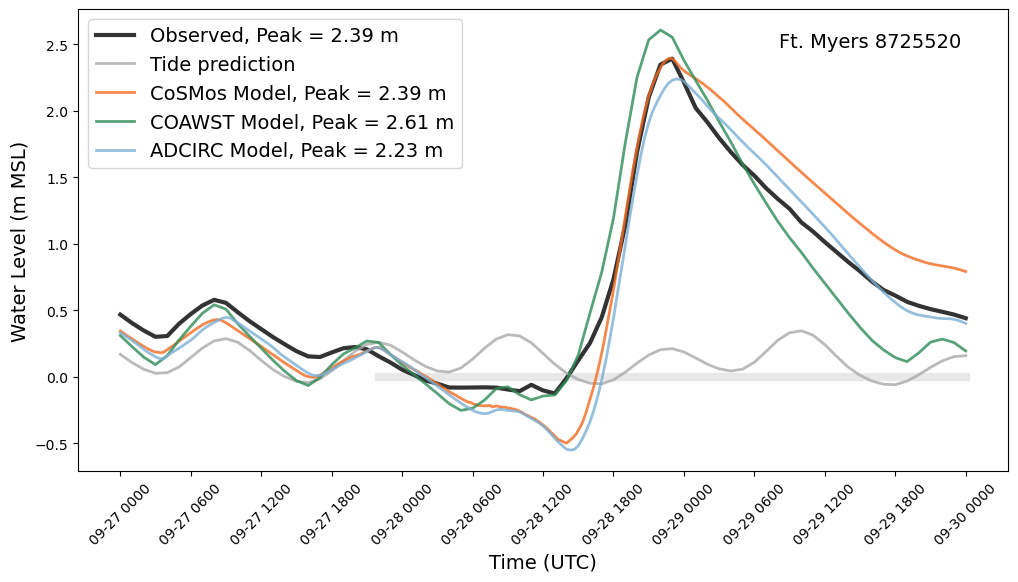

In [14]:
# Plot all three time series

fig, ax = plt.subplots(1,1, figsize=(12, 6))
plt.plot([stats_start_time, stats_end_time],[0, 0],'-',linewidth=6, color='lightgray', alpha = .5)
plt.plot(df_obs["time"], df_obs["water level"], label="Observed, Peak = 2.39 m", color="black", alpha=.8, linewidth=3)
plt.plot(df_obs["time"], df_obs["Predicted (m)"], label="Tide prediction", alpha=.8, color='darkgray', linewidth=2)
plt.plot(df_cosmos["time"], df_cosmos["water level"], label="CoSMos Model, Peak = 2.39 m", color=dutch_orange, alpha=.8, linewidth=2)
plt.plot(df_coawst["time"], df_coawst["water level"], label="COAWST Model, Peak = 2.61 m", color=usgs_green, alpha=.8, linewidth=2)
plt.plot(df_adcirc["time"], df_adcirc["water level"], label="ADCIRC Model, Peak = 2.23 m", color=unc_blue, alpha=.8, linewidth=2)



# Set time axis to label every 6 hours
#plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(byhour=[0, 6, 12, 18]))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H%M"))

# Improve readability
plt.xticks(rotation=45)
plt.xlabel("Time (UTC)", fontsize=14)
plt.ylabel("Water Level (m MSL)", fontsize=14)
plt.legend( fontsize=14)
ts = 'Ft. Myers 8725520'
plt.text(.95,.95, ts, ha='right', va='top', transform=ax.transAxes, fontsize=14)
figdir = 'F:/crs/proj/2025_NOPP_comparison/BAMS_figure/'
plt.savefig(figdir+'BAMS_Ft_Meyers_time_series.png', dpi=200, bbox_inches='tight')
plt.savefig(figdir+'BAMS_Ft_Meyers_time_series.svg', dpi=200, bbox_inches='tight')